# Formula 1 Grand Prix result prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost==1.5.2


     |████████████████████████████████| 173.6 MB 7.0 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 22 17:46:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## This project is aimed towards predicting the future F1 GP winners based on the drivers, constructors or both 
### Things to keep in mind

Before begining the project we need to understand the history of F1 and the diffrent eras in which a certain driver or constructor dominated the whole grid. Here are some important eras of F1 after 2010.  

* 1994-2009 Schumacher (Scuderia Ferrari)
* 2007-2010 Alonso (Renault,Scuderia Ferrari)
* 2011-2013 Vettle (Redbull Racing)
* 2014-Present Hamilton (Mercedes-Benz)

F1 Constructors performance are largely dependent on the FIA techinical regulation for the season after the 2013 season new engine regulation were made (Hybrid era) Mercedes-Benz are most dominat team since followed bu Redbull Racing and Scuderia Ferrari. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')



from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import FunctionTransformer
# Use SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

#Sparse to dense matrix

from sklearn.decomposition import PCA


from sklearn.base import TransformerMixin,BaseEstimator

import xgboost as xgb
from xgboost import XGBClassifier

In [5]:
results = pd.read_csv(r'/content/drive/MyDrive/Formula 1/F1_worldchampionship_1950-2021/results.csv')
races = pd.read_csv(r'/content/drive/MyDrive/Formula 1/F1_worldchampionship_1950-2021/races.csv')
quali = pd.read_csv(r'/content/drive/MyDrive/Formula 1/F1_worldchampionship_1950-2021/qualifying.csv')
drivers = pd.read_csv(r'/content/drive/MyDrive/Formula 1/F1_worldchampionship_1950-2021/drivers.csv')
constructors = pd.read_csv(r'/content/drive/MyDrive/Formula 1/F1_worldchampionship_1950-2021/constructors.csv')
circuit = pd.read_csv(r'/content/drive/MyDrive/Formula 1/F1_worldchampionship_1950-2021/circuits.csv')

#includes weather and distance 
main_df = pd.read_csv(r'/content/drive/MyDrive/Formula 1/Formula1/CSV/main_df2021.csv')


In [6]:
#Merge all dataframes together
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'url_x'} in the result is deprecated and will raise a MergeError in a future version.
  """


In [7]:
#drop the columns which are not important
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [8]:
data.head()


,year,date,grid,points,statusId,position_y,forename,surname,dob,nationality_x,name_y,nationality_y,name,country
0,2009,2009-03-29,1,10.0,1,1,Jenson,Button,1980-01-19,British,Brawn,British,Albert Park Grand Prix Circuit,Australia
1,2009,2009-03-29,2,8.0,1,2,Rubens,Barrichello,1972-05-23,Brazilian,Brawn,British,Albert Park Grand Prix Circuit,Australia
2,2008,2008-03-16,12,0.0,4,13,Jenson,Button,1980-01-19,British,Honda,Japanese,Albert Park Grand Prix Circuit,Australia
3,2007,2007-03-18,14,0.0,11,14,Jenson,Button,1980-01-19,British,Honda,Japanese,Albert Park Grand Prix Circuit,Australia
4,2006,2006-04-02,1,0.0,11,1,Jenson,Button,1980-01-19,British,Honda,Japanese,Albert Park Grand Prix Circuit,Australia


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


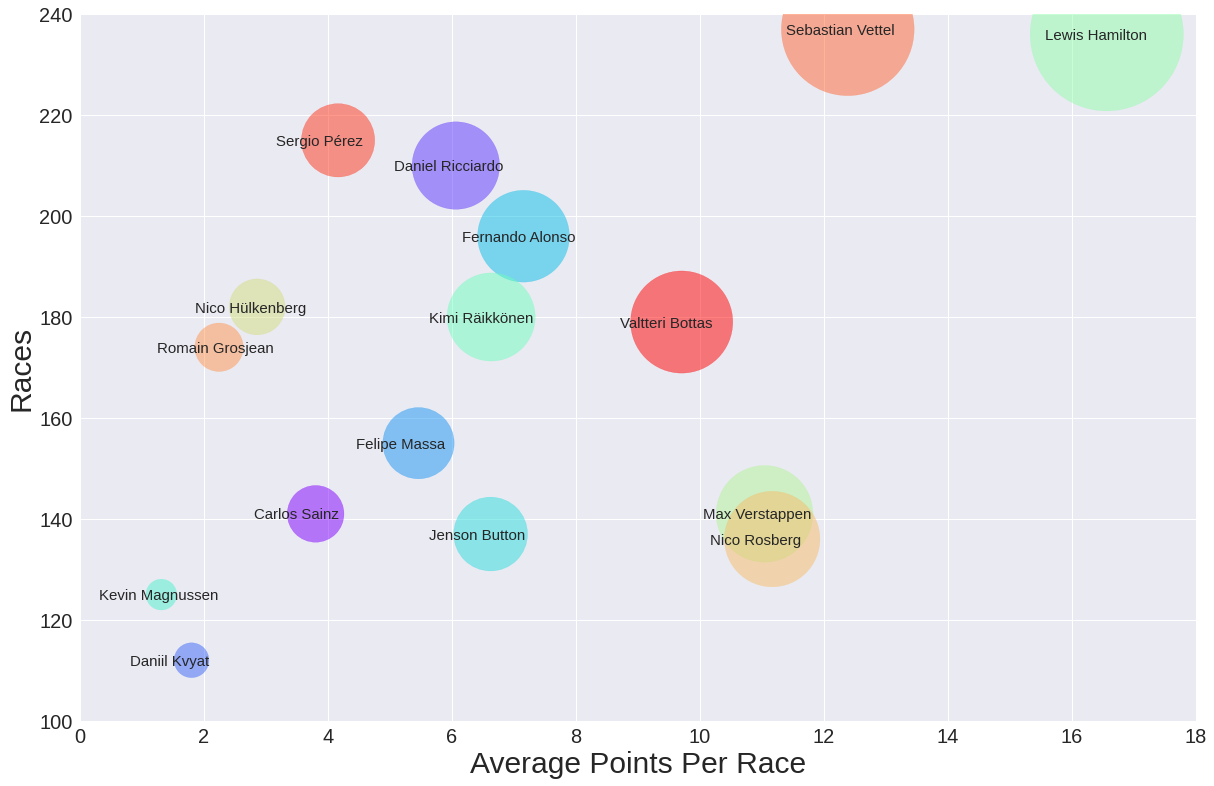

In [9]:

# Merge all three datasets and filter out races before 2010 
m1=pd.merge(results,drivers,on='driverId')
m2=pd.merge(m1,races,on='raceId')

result_v2=m2[m2.year>2009]



result_v2["driver"] = result_v2["forename"] + " " + result_v2["surname"]

# Aggregate total points and average points per race
avg_pts   = result_v2[['driver','points']].groupby("driver").mean()
total_pts = result_v2[['driver','points']].groupby("driver").sum()


# Count number of races for each driver and filter out drivers with less than 100 races
n=result_v2[['driver','raceId']].groupby("driver").count()
num_races=n[n.raceId>100]


# Merge the above summary tables and reset index to create column for driver name
d =pd.merge(avg_pts,total_pts,on='driver')
md=pd.merge(d,num_races,on='driver')
md = md.reset_index()
md.iloc[7,3]=180 #data correction
md.iloc[6,3]=125 #data correction



# Create bubble chart with size of the bubble showing total points scored in the decade

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('figure', titlesize=30)   # fontsize of the figure title

plt.figure(figsize=(20,13))
plt.scatter(md.points_x,md.raceId,s=md.points_y*6,alpha=0.5,cmap='rainbow',c=md.index.to_series())
plt.xlim(0,18)
plt.ylim(100,240)

plt.xlabel("Average Points Per Race")
plt.ylabel("Races")

for x,y,z in zip(md.points_x,md.raceId,md.driver):
    plt.annotate(z,xy=(x-1,y-1))


## F1 Grand Prix structure

a F1 GP runs for 3 days in the weeekend and is made of 3 parts Practice session, Qualify scession and the actual Race.

In the practice sesssion there are 3 stages FP1, FP2 and FP3 this is a free practice scession for teams to test their cars on Friday and saturday.
Qualification session is also made of 3 stages Q1, Q2 and Q3 in this session all drivers compete to set the best lap time and bottom 5 drivers will be eliminated after Q1. top 15 drivers will participate in the Q2 and try to set best lap time and top 10 drivers will move to Q1 where they again set best best lap time they can and the cars position at the start of the race will be decided based on their qualifying time driver with best time will get to start at the front.
Sunday scession is the Race and points will be awarded to top 10 drivers and top three will get to enjoy podium.
This happens for a full season for a whole year at diffrent circuits and driver with the highest points will be awarded World championship and team with highest points will get Constructorschampionship(each team have two cars and two drivers)

In [10]:
#Look at lengths of thw two data frames to work with, main_df has a weather and circuit distance feature that could be interesting to use.

#print(main_df.tail())
print(len(main_df))
print(len(data))

      Unnamed: 0  season  round  ... finish_position points filled_splits
3054        3292    2021     22  ...            16.0    0.0      0.067527
3055        3293    2021     22  ...            17.0    0.0      0.067527
3056        3294    2021     22  ...            18.0    0.0      0.067527
3057        3295    2021     22  ...            19.0    0.0      0.067527
3058        3296    2021     22  ...            20.0    0.0      0.067527

[5 rows x 22 columns]
3059
9124


In [11]:
#considering data points from 2014
data = data[data['year']>=2014]
data.sort_values(by=['year'])

,year,date,grid,points,statusId,position_y,forename,surname,dob,nationality_x,name_y,nationality_y,name,country
7949,2014,2014-10-12,6,6.0,1,7,Daniel,Ricciardo,1989-07-01,Australian,Red Bull,Austrian,Sochi Autodrom,Russia
5023,2014,2014-09-21,10,0.0,1,10,Daniil,Kvyat,1994-04-26,Russian,Toro Rosso,Italian,Marina Bay Street Circuit,Singapore
5862,2014,2014-11-09,17,0.0,11,14,Daniil,Kvyat,1994-04-26,Russian,Toro Rosso,Italian,Autódromo José Carlos Pace,Brazil
5022,2014,2014-09-21,12,8.0,1,12,Jean-Éric,Vergne,1990-04-25,French,Toro Rosso,Italian,Marina Bay Street Circuit,Singapore
4206,2014,2014-08-24,16,0.0,6,16,Jules,Bianchi,1989-08-03,French,Marussia,Russian,Circuit de Spa-Francorchamps,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7964,2021,2021-09-26,7,0.0,1,8,Lance,Stroll,1998-10-29,Canadian,Aston Martin,British,Sochi Autodrom,Russia
7967,2021,2021-09-26,13,4.0,1,16,Kimi,Räikkönen,1979-10-17,Finnish,Alfa Romeo,Swiss,Sochi Autodrom,Russia
7970,2021,2021-09-26,17,0.0,11,18,Antonio,Giovinazzi,1993-12-14,Italian,Alfa Romeo,Swiss,Sochi Autodrom,Russia
7948,2021,2021-09-26,8,2.0,1,9,Sergio,Pérez,1990-01-26,Mexican,Red Bull,Austrian,Sochi Autodrom,Russia


In [12]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [13]:

data.head(2)

,year,date,quali_pos,points,statusId,position,forename,surname,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,driver
34,2017,2017-03-26,11,0.0,11,12,Nico,Hülkenberg,1987-08-19,German,Renault,French,Albert Park Grand Prix Circuit,Australia,Nico Hülkenberg
35,2018,2018-03-25,7,6.0,1,8,Nico,Hülkenberg,1987-08-19,German,Renault,French,Albert Park Grand Prix Circuit,Australia,Nico Hülkenberg


In [14]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine' if x=='Renault' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [16]:
#Feature Engineering and cleaning data so data is most up to date with current/accurate names
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [17]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [18]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

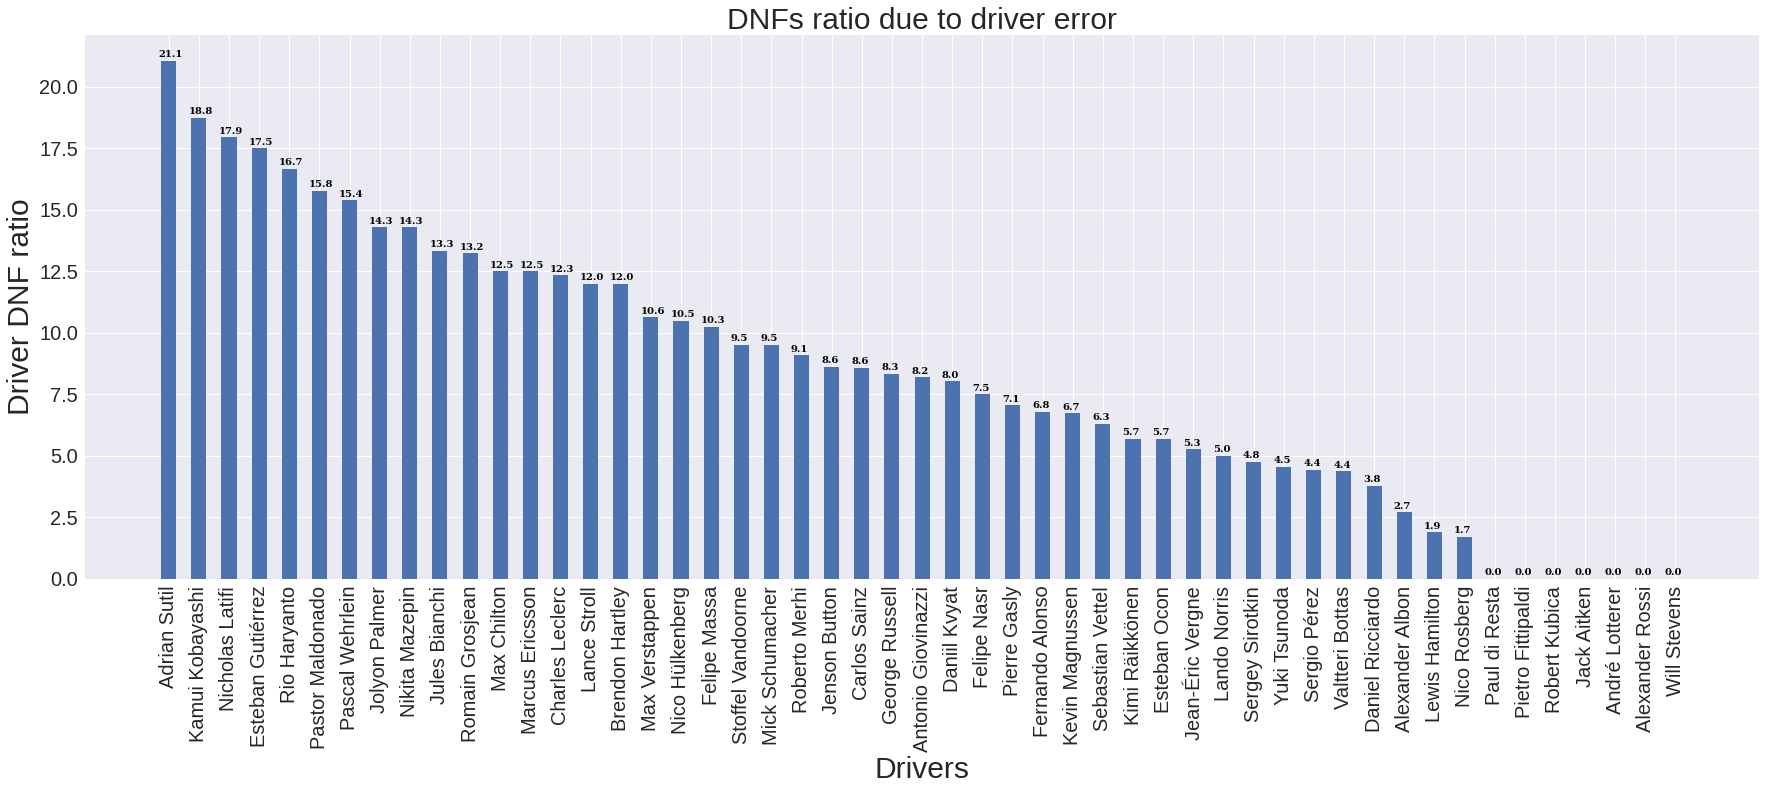

In [19]:
# Do not finish plot for drivers
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

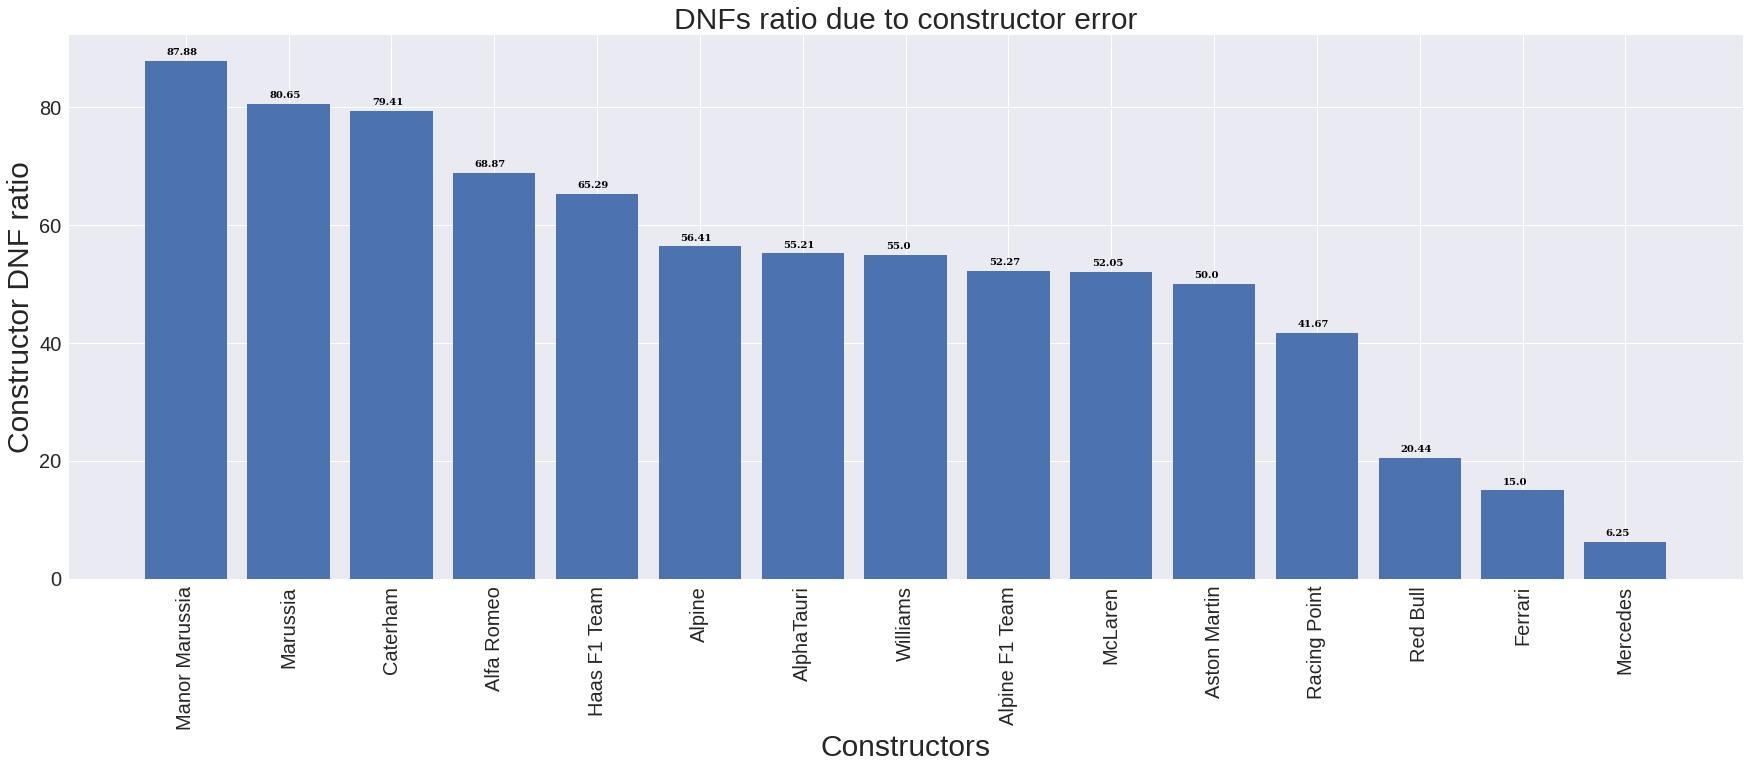

In [20]:
# Do not finish plot for constructor teams
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs ratio due to constructor error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

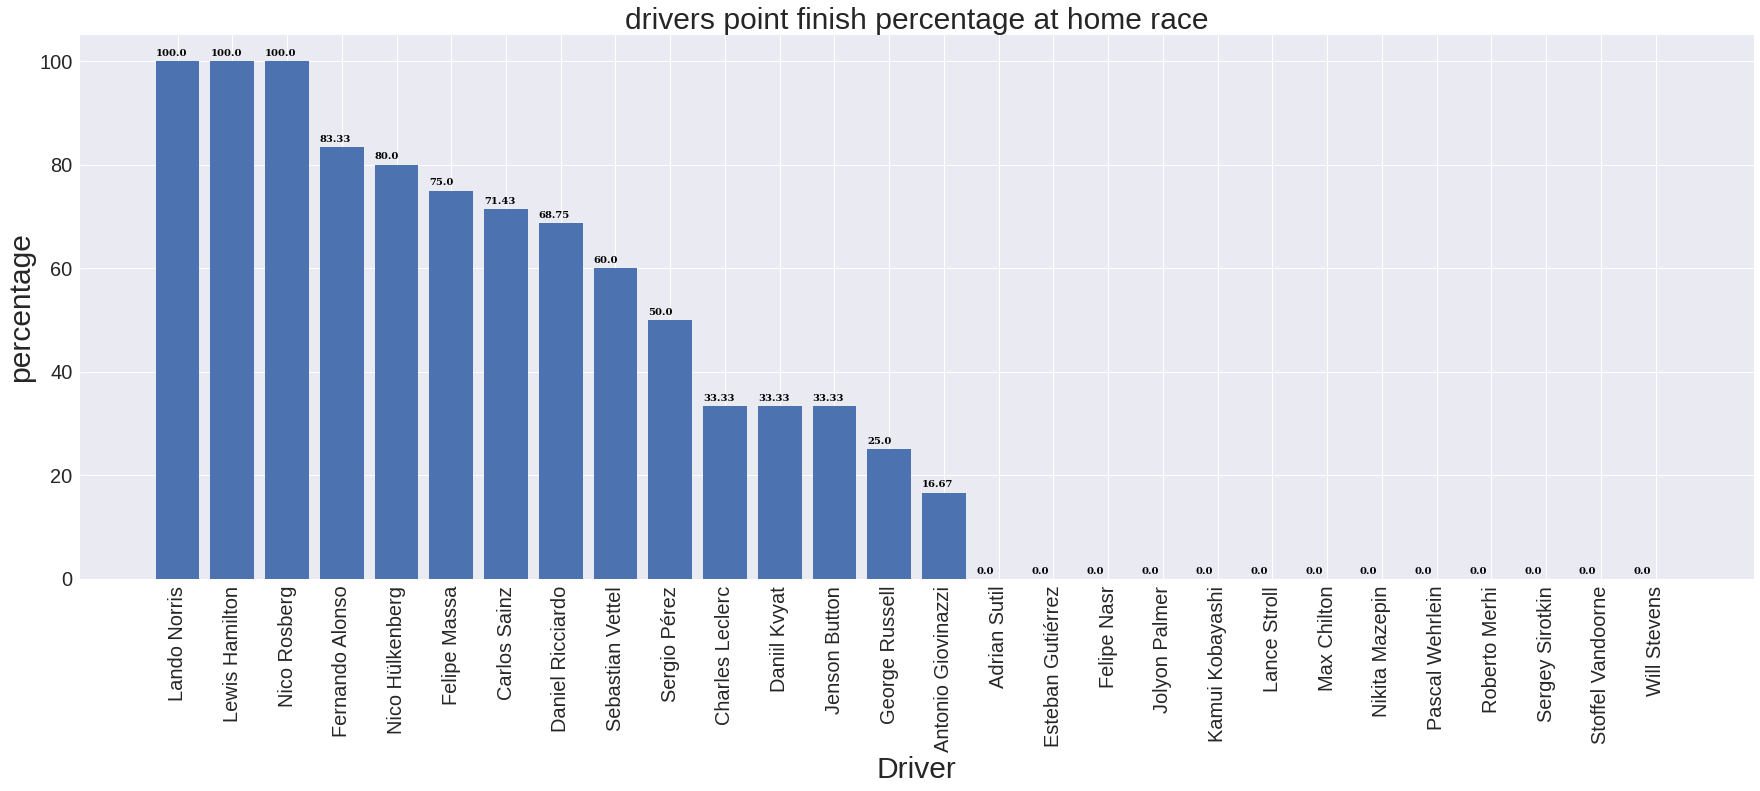

In [21]:
#drivers home points plot for drivers from 2014 on
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('percentage')
plt.title('drivers point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

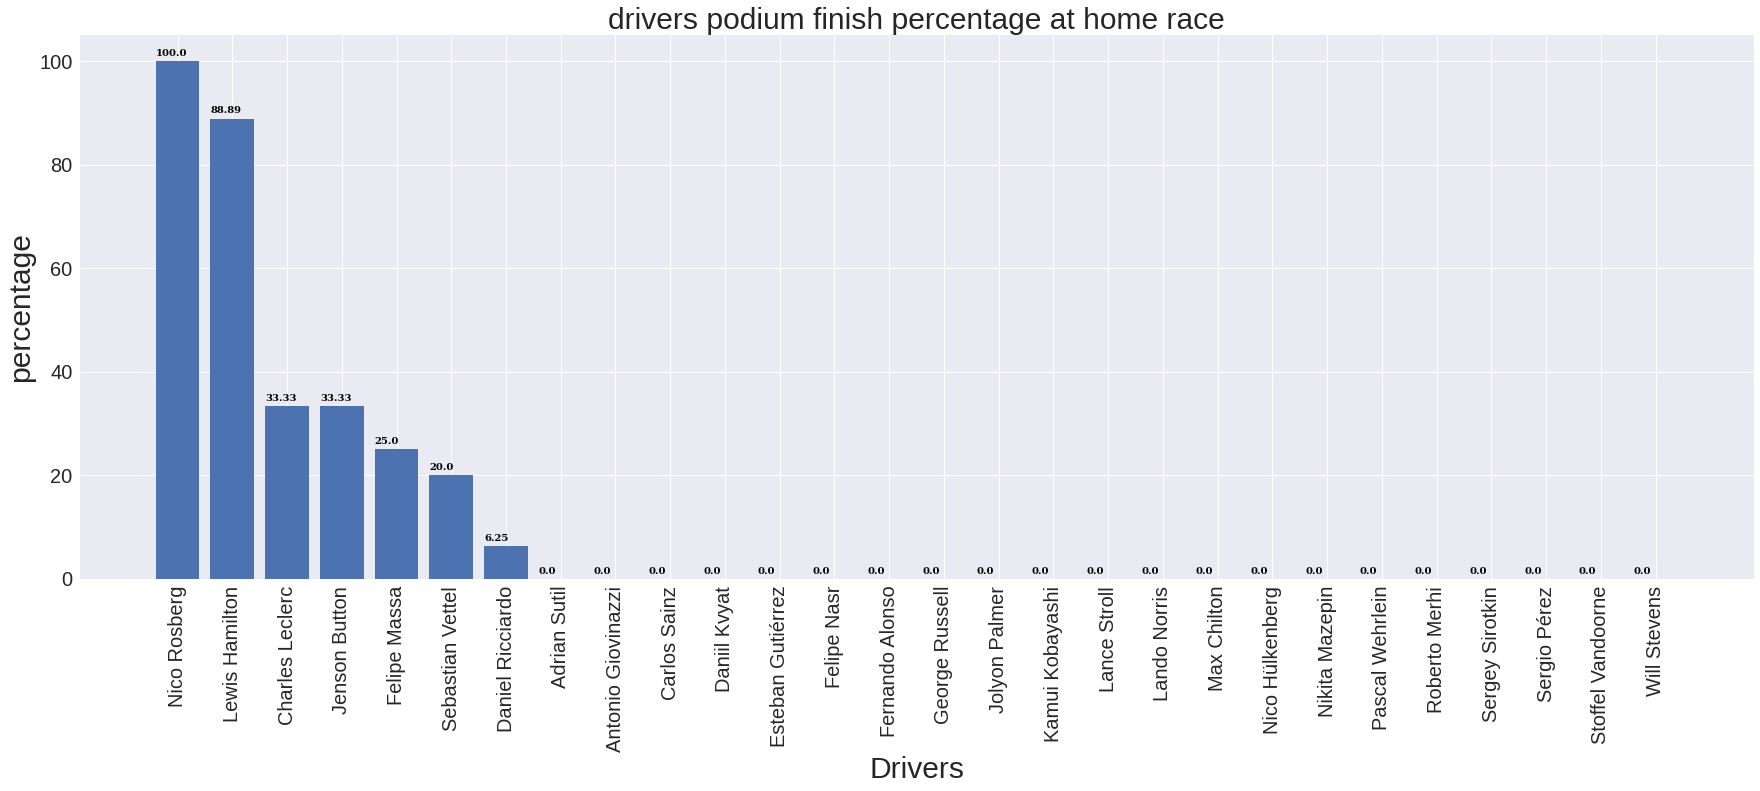

In [22]:
#drivers home podium finish plot for drivers from 2014-2021
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('drivers podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

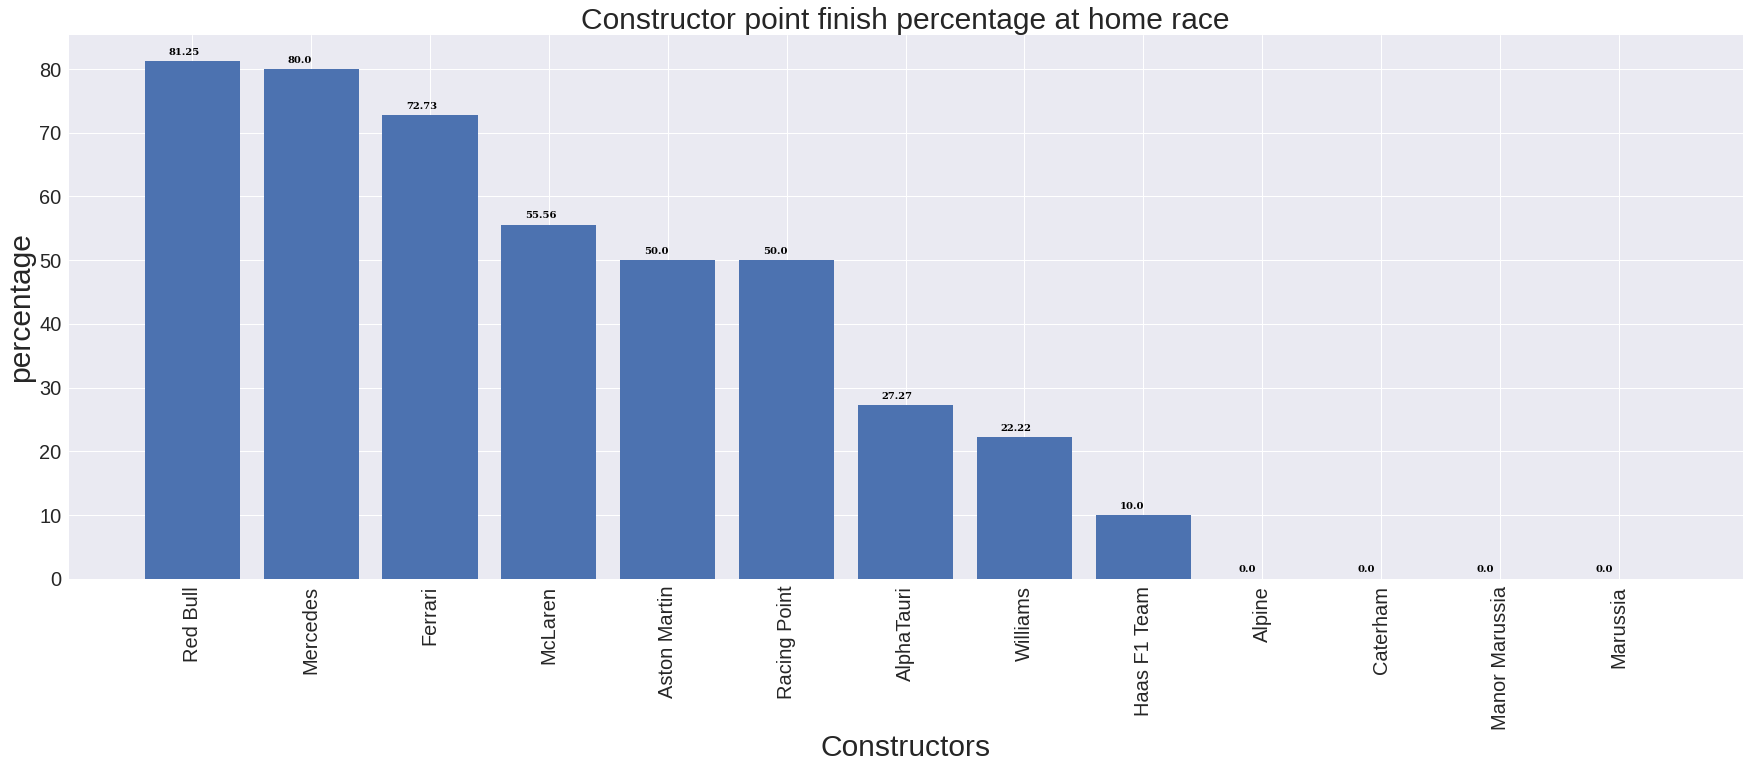

In [23]:
#Constructor home points finish plot for drivers from 2014-2021
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

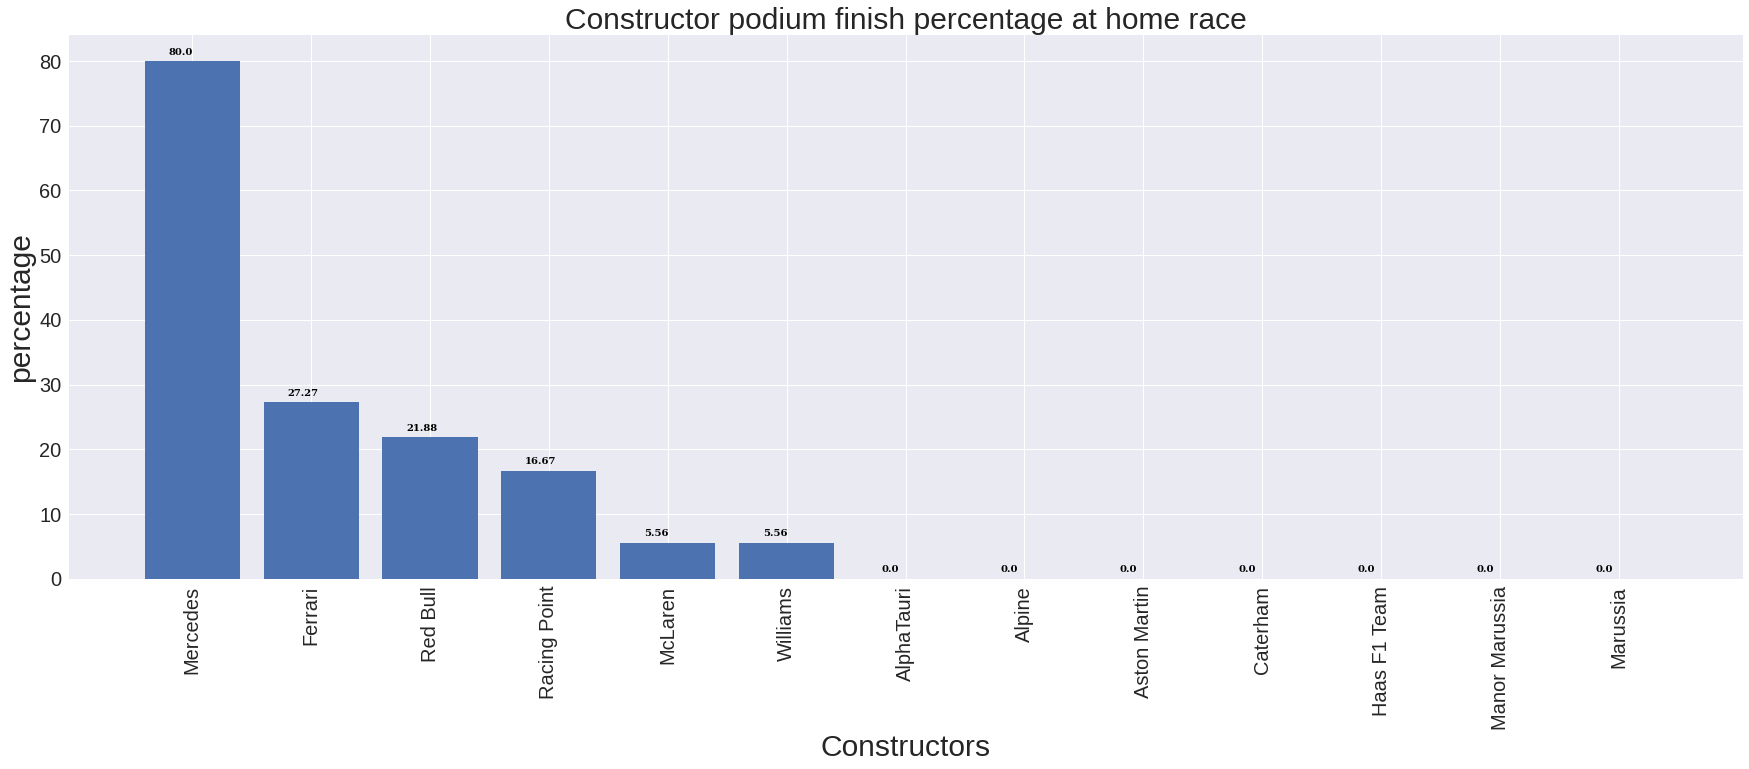

In [24]:
#constructor home points finish plot for drivers from 2014-2021
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [25]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [26]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

In [27]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

### Model considering both drivers and constructors

In [28]:

comparison_dict ={'model':[],
                  'params': [],
                  'score': []}

In [29]:
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('cleaned_data.csv',index=False)

In [30]:
# create a multi class to split by podium, points and no points scored
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [31]:

#X variable for use of both drivers and constructor cross validation and modeling

x = data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver','constructor','constructor_relaiblity','active_constructor' ]]



In [32]:
sc  = preprocessing.StandardScaler()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
x['age_at_gp_in_days'] = sc.fit_transform(x[['age_at_gp_in_days']])
X = x.drop(['position','active_driver','active_constructor'],1)
y = x['position'].apply(lambda x: position_index(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [33]:

#xgb_model = XGBClassifier(objective="multi:softprob",use_label_encoder=False,error_score='raise')

In [34]:
#cross validation for diffrent models
models = [XGBClassifier(objective="multi:softprob"), DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['XGBClassifier','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier : 0.9401234567901234
DecisionTreeClassifier : 0.925
RandomForestClassifier : 0.9438271604938272
SVC : 0.9148148148148147
GaussianNB : 0.8604938271604938
KNeighborsClassifier : 0.892283950617284


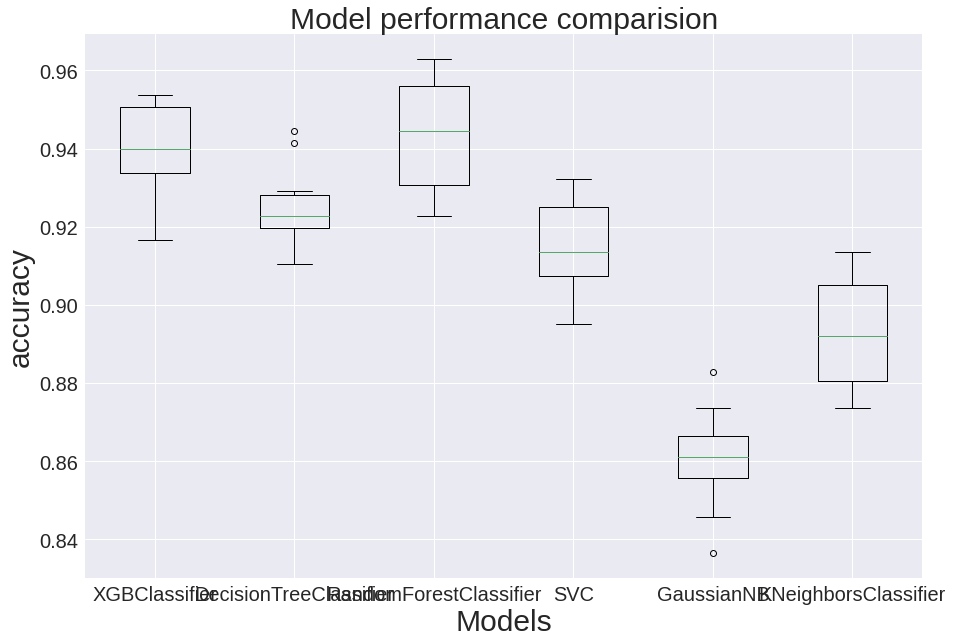

In [35]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

### Model considering only drivers

In [36]:
#X variable for the driver only modeling
x_d= data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver','points']]

In [37]:
#make sure only active drivers are in the modeling.
x_d = x_d[x_d['active_driver']==1]

In [38]:
sc  = preprocessing.StandardScaler()

le = LabelEncoder()
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['driver'] = le.fit_transform(x_d['driver'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])
X_d = x_d.drop(['position','active_driver'],1)
y_d = x_d['position'].apply(lambda x: position_index(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [39]:
#cross validation for diffrent models

#remove Log regression as its for binary classification problems
models = [XGBClassifier(objective="multi:softprob"),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['xgb','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=None)
    result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb : 0.9308079572785456
DecisionTreeClassifier : 0.9032346826464475
RandomForestClassifier : 0.9353267294443766
SVC : 0.8996127349068527
GaussianNB : 0.8385858709388121
KNeighborsClassifier : 0.8625290448819859


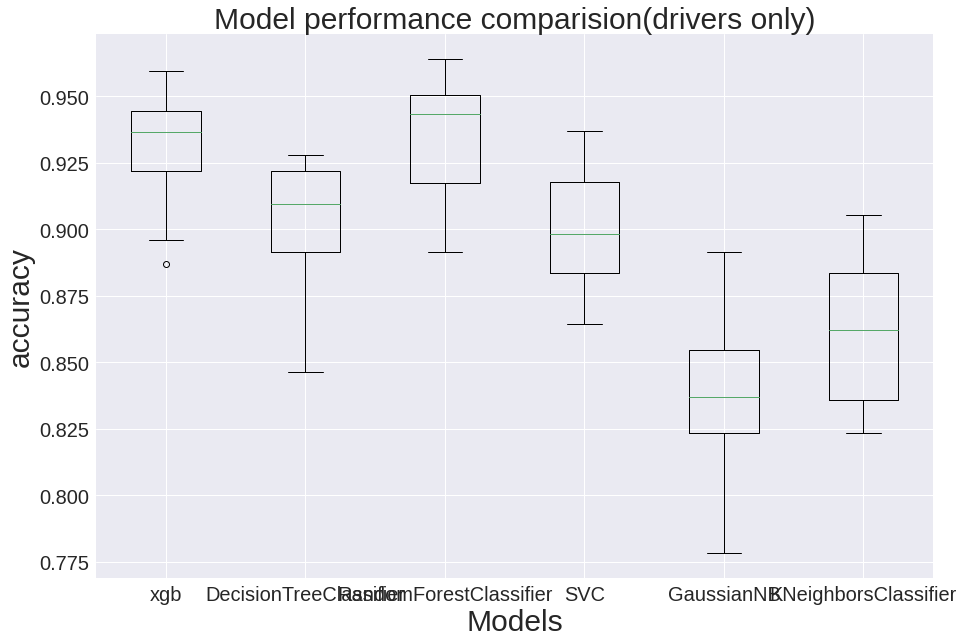

In [40]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(drivers only)')
plt.show()

### Model considering only constructor

In [41]:
#X variable for construtor team 
x_c = data[['GP_name','quali_pos','constructor','position','constructor_relaiblity','active_constructor','points']]

In [42]:
# only active constructor teams are in the modeling 
x_c = x_c[x_c['active_constructor']==1]

In [43]:
sc  = preprocessing.StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])
X_c = x_c.drop(['position','active_constructor'],1)
y_c = x_c['position'].apply(lambda x: position_index(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


In [44]:
#cross validation for diffrent models
models = [XGBClassifier(objective="multi:softprob"),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['xgb','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_const = []
results_const = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
    #NOTE: added 'precision', 'recall', 'f1'], this may mess up the cell
    result = cross_val_score(model,X_c,y_c,cv=cv,scoring='accuracy')
    mean_results_const.append(result.mean())
    results_const.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb : 0.9337743861977439
DecisionTreeClassifier : 0.9119442601194425
RandomForestClassifier : 0.9366794956867949
SVC : 0.9192130059721301
GaussianNB : 0.8340570670205706
KNeighborsClassifier : 0.8831811546118116


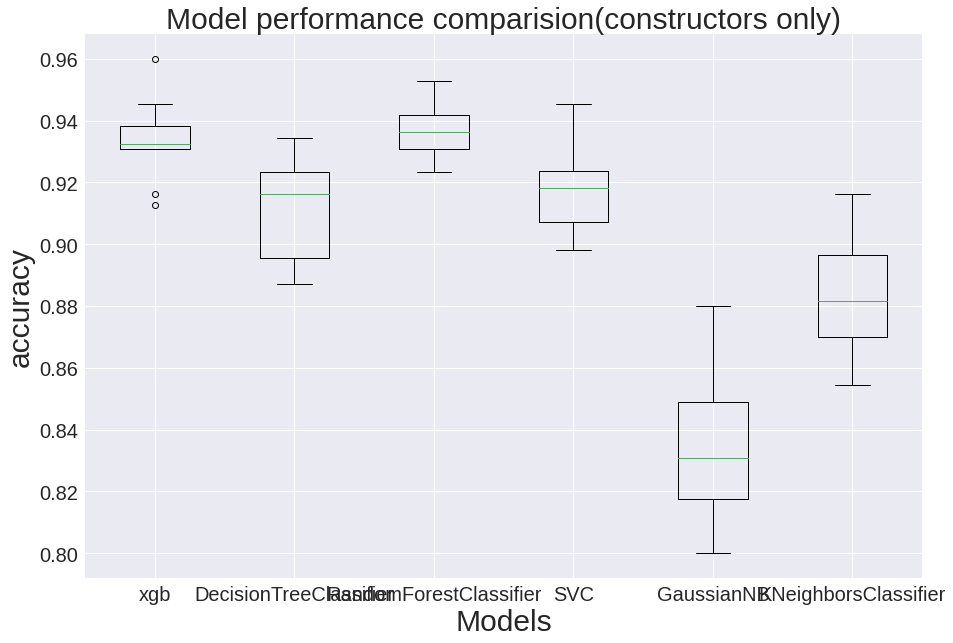

In [45]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_const,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(constructors only)')
plt.show()

#### lets see mean score of our three assumptions

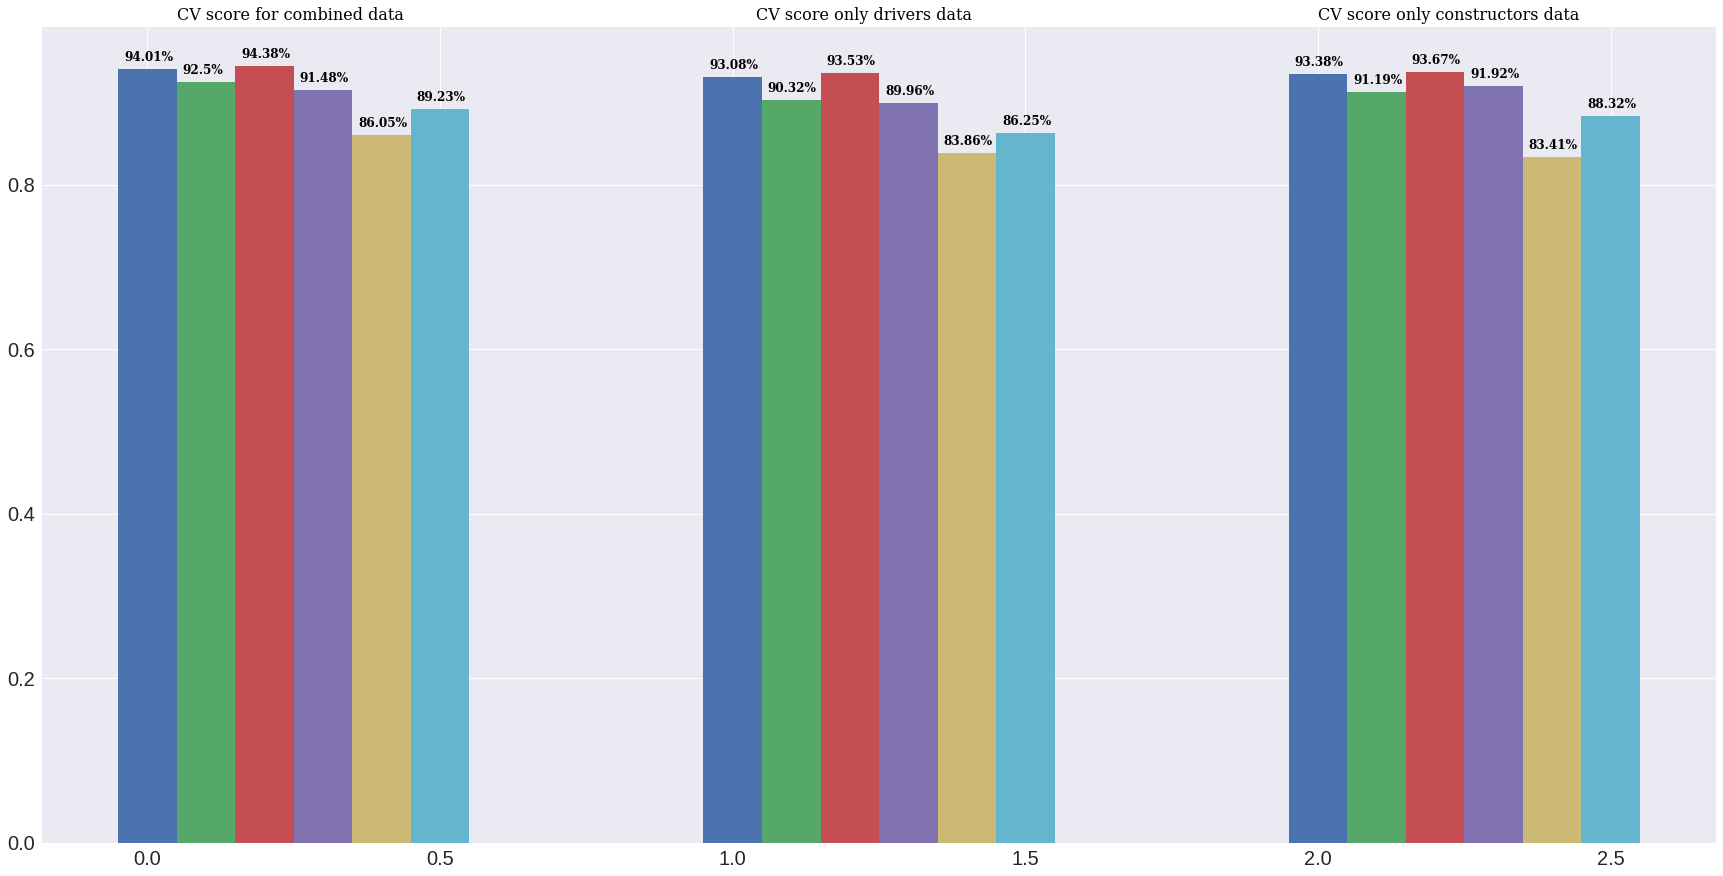

In [46]:
lr = [mean_results[0],mean_results_dri[0],mean_results_const[0]]
dtc = [mean_results[1],mean_results_dri[1],mean_results_const[1]]
rfc = [mean_results[2],mean_results_dri[2],mean_results_const[2]]
svc = [mean_results[3],mean_results_dri[3],mean_results_const[3]]
gnb = [mean_results[4],mean_results_dri[4],mean_results_const[4]]
knn = [mean_results[5],mean_results_dri[5],mean_results_const[5]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':16
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center')
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center')
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center')
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center')
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center')
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center')
plt.text(0.05,1,'CV score for combined data',fontdict=font1)
plt.text(1.04,1,'CV score only drivers data',fontdict=font1)
plt.text(2,1,'CV score only constructors data',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.show()

In [47]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,8,10,15,20]
min_samples_leaf = [1,2,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

In [48]:
rf_rand = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=100,cv=10,verbose=2,n_jobs=-1)
rf_random.fit(X,y)
rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 1600}

In [49]:
rf = RandomForestClassifier(n_estimators=1800,min_samples_split=15,min_samples_leaf=1,max_features='auto',max_depth=100,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [50]:

X_test.columns

Index(['GP_name', 'quali_pos', 'driver', 'age_at_gp_in_days',
       'driver_confidence', 'constructor', 'constructor_relaiblity'],
      dtype='object')

In [51]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()

In [52]:

model = rf
result = model.score(X_test, y_test)
print(result)

0.9567901234567902


In [53]:

# Save the model
import joblib
model = rf
joblib.dump(model, '/content/drive/MyDrive/Formula 1/f1model_rf.sav.joblib')

['/content/drive/MyDrive/Formula 1/f1model_rf.sav.joblib']

In [54]:

xgb = XGBClassifier(objective="multi:softprob")
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
cnf_mat_xgb = confusion_matrix(y_test,y_pred)
cnf_mat_xgb = cnf_mat_xgb/cnf_mat_xgb.sum()

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [55]:

X_test

,GP_name,quali_pos,driver,age_at_gp_in_days,driver_confidence,constructor,constructor_relaiblity
8442,15,3,8,-0.053866,0.962264,13,0.795597
8445,15,4,9,-1.167378,0.919643,13,0.795597
8446,15,4,29,-1.633438,0.893617,13,0.795597
8447,15,16,29,-1.442611,0.893617,13,0.795597
8449,15,3,29,-1.053615,0.893617,13,0.795597
...,...,...,...,...,...,...,...
9119,19,10,4,0.073003,0.918033,0,0.311321
9120,19,19,30,-0.935658,0.904762,7,0.347107
9121,19,20,34,-0.925173,0.857143,7,0.347107
9122,19,6,38,-0.338535,0.929412,1,0.447950


In [56]:
y_pred_xgb

array([1, 2, 2, 3, 1, 1, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 1, 2, 1, 2, 1, 3, 2, 2, 2,
       2, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 3, 2, 2,
       3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2,
       2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3,
       3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 1, 1, 1, 2, 3, 3, 3, 3,
       2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 1,
       1, 1, 2, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3,
       3, 3, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3,
       2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 3, 3, 3, 2, 3,

In [57]:

# Save the model
import joblib
model = xgb
joblib.dump(model, '/content/drive/MyDrive/Formula 1/f1model_XGB.sav.joblib')

['/content/drive/MyDrive/Formula 1/f1model_XGB.sav.joblib']

In [58]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
cnf_mat_svc = confusion_matrix(y_test,y_pred)
cnf_mat_svc = cnf_mat_svc/cnf_mat_svc.sum()

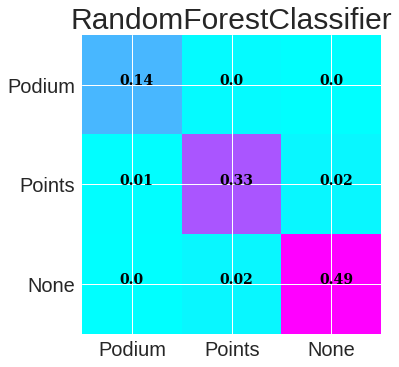

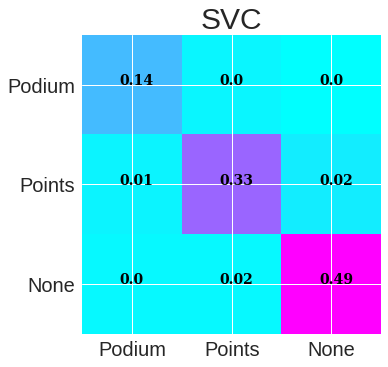

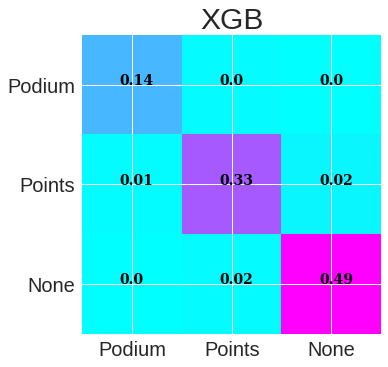

In [59]:
font3 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':14
}
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
fig3,ax3 = plt.subplots()
ax1.set_xticks(np.arange(3))
ax1.set_yticks(np.arange(3))
ax1.set_xticklabels(['Podium','Points','None'])
ax1.set_yticklabels(['Podium','Points','None'])
ax1.set_title('RandomForestClassifier')
im_rf = ax1.imshow(cnf_mat_rf,cmap='cool')
for i in range(3):
    for j in range(3):
            ax1.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

ax2.set_xticks(np.arange(3))
ax2.set_yticks(np.arange(3))
ax2.set_xticklabels(['Podium','Points','None'])
ax2.set_yticklabels(['Podium','Points','None'])
ax2.set_title('SVC')
im_svc = ax2.imshow(cnf_mat_svc,cmap='cool')
for i in range(3):
    for j in range(3):
            ax2.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

ax3.set_xticks(np.arange(3))
ax3.set_yticks(np.arange(3))
ax3.set_xticklabels(['Podium','Points','None'])
ax3.set_yticklabels(['Podium','Points','None'])
ax3.set_title('XGB')
im_svc = ax3.imshow(cnf_mat_xgb,cmap='cool')
for i in range(3):
    for j in range(3):
            ax3.text(i-0.125,j,round(cnf_mat_rf[i,j],2),fontdict=font3)

In [66]:
rf_pression = precision_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')

svc_pression = precision_score(y_test, y_pred_svc, average='micro')
svc_f1 = f1_score(y_test,y_pred_svc,average='macro')
svc_recall = recall_score(y_test,y_pred_svc,average='macro')

xgb_pression = precision_score(y_test, y_pred_xgb, average='macro')
xgb_f1 = f1_score(y_test,y_pred_xgb,average='macro')
xgb_recall = recall_score(y_test,y_pred_xgb,average='macro')


metrics_dict ={
    'RandomForestClassifier':{'precision_score':rf_pression,'f1_score':rf_f1,'recall_score':rf_recall},
    'SVC':{'precision_score':svc_pression,'f1_score':svc_f1,'recall_score':svc_recall},
    'XGB':{'precision_score':xgb_pression,'f1_score':xgb_f1, 'recall_score':xgb_recall},
           }
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,RandomForestClassifier,SVC,XGB
precision_score,0.959199,0.901235,0.955658
f1_score,0.955004,0.881551,0.952372
recall_score,0.951147,0.888502,0.949260


In [61]:
import numpy as np

from scipy.stats import uniform, randint


from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

# Need to try XGboost with this data set below.  

TO BE CONTINUED 

- Neural networks
- Regressional Models


In [62]:

data

,year,date,quali_pos,points,statusId,position,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,driver_confidence,constructor_relaiblity,active_driver,active_constructor
34,2017,2017-03-26,11,0.0,11,12,1987-08-19,Ger,Alpine,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,10812,0,0,0,1,0.895161,0.435897,0,0
35,2018,2018-03-25,7,6.0,1,8,1987-08-19,Ger,Alpine,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11176,0,0,0,0,0.895161,0.435897,0,0
36,2019,2019-03-17,11,6.0,11,11,1987-08-19,Ger,Alpine,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11533,0,0,0,1,0.895161,0.435897,0,0
39,2019,2019-03-17,12,0.0,137,12,1989-07-01,Aus,Alpine,Fre,Albert Park Grand Prix Circuit,Aus,Daniel Ricciardo,10851,1,0,1,0,0.962264,0.435897,1,0
40,2016,2016-03-20,14,0.0,1,15,1992-10-05,Dan,Alpine,Fre,Albert Park Grand Prix Circuit,Aus,Kevin Magnussen,8567,0,0,0,0,0.932773,0.435897,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9119,2021,2021-12-05,10,2.0,1,10,1993-12-14,Ita,Alfa Romeo,Swi,Jeddah Street Circuit,Sau,Antonio Giovinazzi,10218,0,0,0,0,0.918033,0.311321,1,1
9120,2021,2021-12-05,19,0.0,3,19,1999-03-22,Ger,Haas F1 Team,Ame,Jeddah Street Circuit,Sau,Mick Schumacher,8294,0,0,1,0,0.904762,0.347107,0,1
9121,2021,2021-12-05,20,0.0,4,20,1999-03-02,Rus,Haas F1 Team,Ame,Jeddah Street Circuit,Sau,Nikita Mazepin,8314,0,0,1,0,0.857143,0.347107,0,1
9122,2021,2021-12-05,6,8.0,1,6,1996-02-07,Fre,AlphaTauri,Ita,Jeddah Street Circuit,Sau,Pierre Gasly,9433,0,0,0,0,0.929412,0.447950,1,1


In [63]:
#Choose between data frame with specific features

#x_c = data[['driver','quali_pos','constructor','position','constructor_relaiblity','active_constructor','points','year']]
#df = x_c.copy()


data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_df.csv')





In [64]:
df = data.copy()

train = df[df.season <2020]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)



In [65]:

def score_classification(model):
    score = 0
    for circuit in df[df.season == 2020]['round'].unique():

        test = df[(df.season == 2020) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        prediction_df['actual'] = y_test.reset_index(drop = True)
        prediction_df.sort_values('proba_1', ascending = False, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)

        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2020]['round'].unique().max()
    return model_score

# Neural network
from sklearn.neural_network import MLPClassifier

params={'hidden_layer_sizes': [(80,20,40,5), (75,25,50,10)], 
        'activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'solver': ['lbfgs', 'sgd', 'adam', 'logistic'], 
        'alpha': np.logspace(-4,2,20)} 


for hidden_layer_sizes in params['hidden_layer_sizes']:
    for activation in params['activation']:
        for solver in params['solver']:
            for alpha in params['alpha']:
                model_params = (hidden_layer_sizes, activation, solver, alpha )
                model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                                      activation = activation, solver = solver, alpha = alpha, random_state = 1)
                model.fit(X_train, y_train)

                model_score = score_classification(model)

                comparison_dict['model'].append('neural_network_classifier')
                comparison_dict['params'].append(model_params)
                comparison_dict['score'].append(model_score)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


ValueError: ignored

In [ ]:
def score_regression(model):
    score = 0
    for circuit in df[df.season == 2019]['round'].unique():

        test = df[(df.season == 2019) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict(X_test), columns = ['results'])
        prediction_df['podium'] = y_test.reset_index(drop = True)
        prediction_df['actual'] = prediction_df.podium.map(lambda x: 1 if x == 1 else 0)
        prediction_df.sort_values('results', ascending = True, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)

        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2019]['round'].unique().max()
    return model_score

In [ ]:

comparison_dict ={'model':[],
                  'params': [],
                  'score': []}

In [ ]:
# Linear Regression

params={'fit_intercept': ['True', 'False']}

for fit_intercept in params['fit_intercept']:
    model_params = (fit_intercept)
    model = LinearRegression(fit_intercept = fit_intercept)
    model.fit(X_train, y_train)
            
    model_score = score_regression(model)
            
    comparison_dict['model'].append('linear_regression')
    comparison_dict['params'].append(model_params)
    comparison_dict['score'].append(model_score)


In [ ]:
# Random Forest Regressor

params={'criterion': ['squared_error'],
        'max_features': [0.8, 'auto', None],
        'max_depth': list(np.linspace(5, 55, 26)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestRegressor(criterion = criterion,
                                          max_features = max_features, max_depth = max_depth, random_state = 1)
            model.fit(X_train, y_train)
            
            model_score = score_regression(model)
            
            comparison_dict['model'].append('random_forest_regressor')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)

In [ ]:

pd.DataFrame(comparison_dict).groupby('model')['score'].max()

In [ ]:
df

In [ ]:
#example for XGBoost multi classifier



train = df[df.season <2020]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)


In [ ]:
from xgboost import XGBClassifier

params1 = {
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.3, 0.4, 0.5, 0.7, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
            'max_depth': [5, 8, 15, 25, 30],
            'eval_metric': ['error']
        }

params = {
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.3, 0.5, 0.7, 1, 1.5, 2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
            'max_depth': [8, 15, 30],
            'eval_metric': ['error']}

            
clf = GridSearchCV(estimator=XGBClassifier(), param_grid=params)
clf.fit(X_train, y_train)
print(clf.best_params_)


In [ ]:

categorical_pipeline = Pipeline([('keep_cat', keep_cat),
                                 
                                 ('One Hot encoder', ohe),
                                 ('to_dense', to_dense),
                                 ('pca', pca)


insert = FeatureUnion([('categorical_pipeline', categorical_pipeline)
                     ])

final_pipe = Pipeline([('union', union)
                       
                      ])